# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [80]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [81]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что мы используем "predict_proba", а не "predict". Так как классификатор у нас рандомный, а также бинарный, то у каждого значения, выданного классификатором, вероятность должна быть 0,5, что мы и видим.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [82]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


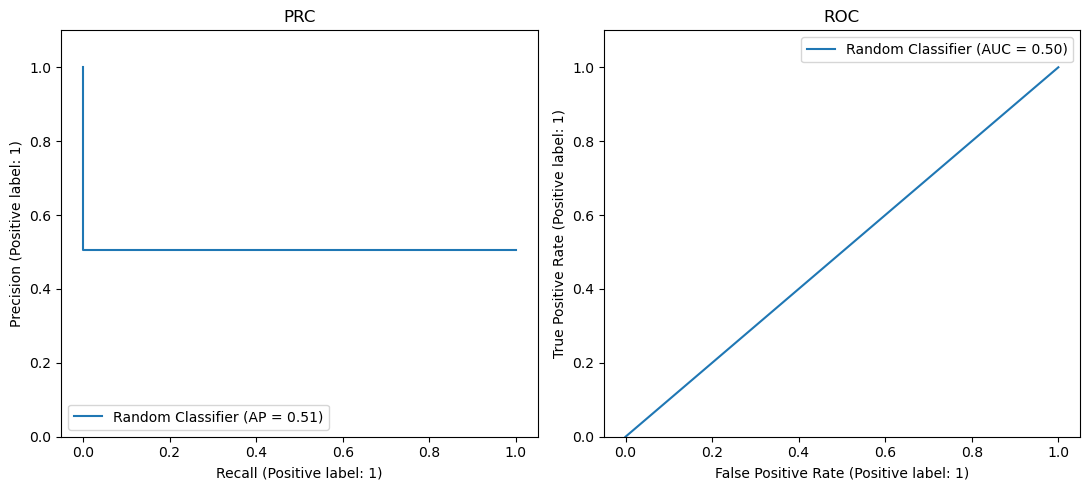

In [83]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [84]:
# dataframe для сравнения
# методов классификации по метрикам
def make_df(y_test_, y_pred_, name):
  df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
  precision, recall, _ = precision_recall_curve(y_test_, y_pred_)
    # добавление очередной строки с характеристиками метода
  df_metrics.loc[name] = [
        auc(recall, precision),
        roc_auc_score(y_test_, y_pred_),
        0
  ]

    # по аналогии результаты следующих экспериментов можно будет собрать в табличку
  return df_metrics
res_random_df = make_df(y_test, y_random, 'Random Classifier')
res_random_df

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [85]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = {'C': np.logspace(-3, 3, 10)}

grid_search = GridSearchCV(SVC(kernel='linear', max_iter=100000, random_state=42), param_grid,
                           scoring='average_precision', cv=3)

grid_search.fit(X_train, y_train)

# Getting the best C value and corresponding score
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_
best_C, best_score

(0.001, 0.8159667716665182)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [86]:
svc_classifier = SVC(kernel='linear', C=best_C, max_iter=100000, random_state=42)
svc_classifier.fit(X_train, y_train)
y_pred_proba_svc = svc_classifier.decision_function(X_test)
y_pred_proba_svc

array([ 0.61928493, -3.29262419, -1.06780666, ..., -2.00249302,
        1.38588673,  1.97488564])

SVC classifier metrics
AUC-PR: 0.82136
AUC-ROC: 0.84726


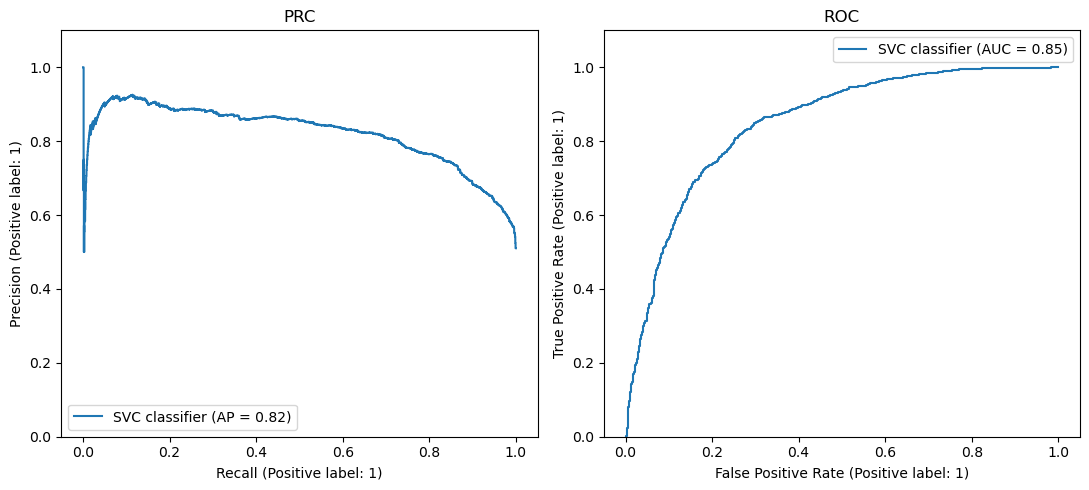

In [87]:
depict_pr_roc(y_test, y_pred_proba_svc, 'SVC classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [88]:
res_svc_df = make_df(y_test, y_pred_proba_svc, 'SVC classifier')
print(res_svc_df)
print(res_random_df)

                  AUC_PR   AUC_ROC  reg_const
SVC classifier  0.821358  0.847259        0.0
                     AUC_PR  AUC_ROC  reg_const
Random Classifier  0.752833      0.5        0.0




---

Видим, что AUC-PR и AUC-ROC значительно улучшились. AUC-ROC на 0,35 лучше рандомного классификатора.


---



__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [89]:
from sklearn.linear_model import LogisticRegression
# Setting up GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(penalty='l2', max_iter=10000, random_state=42),
                              param_grid, scoring='roc_auc', cv=5)

# Fitting GridSearchCV to the training data
grid_search_lr.fit(X_train, y_train)

# Getting the best C value for Logistic Regression and corresponding score
best_C_lr = grid_search_lr.best_params_['C']

# Training the Logistic Regression model with the best C
lr_model = LogisticRegression(penalty='l2', C=best_C_lr, max_iter=10000, random_state=42)
lr_model.fit(X_train, y_train)

# Predicting probabilities on the test set
y_pred_proba_lr = lr_model.decision_function(X_test)

Logistic Regression Classifier metrics
AUC-PR: 0.82912
AUC-ROC: 0.84788


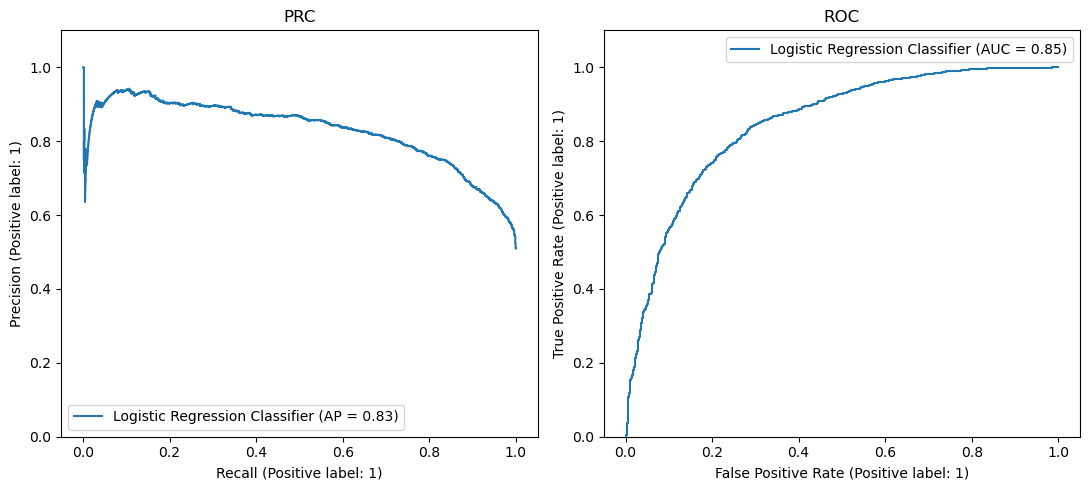

In [90]:
depict_pr_roc(y_test, y_pred_proba_lr, 'Logistic Regression Classifier')

In [91]:
res_log_df = make_df(y_test, y_pred_proba_lr, 'Logistic Regression Classifier')
print(res_log_df)
print(res_random_df)

                                 AUC_PR   AUC_ROC  reg_const
Logistic Regression Classifier  0.82912  0.847879        0.0
                     AUC_PR  AUC_ROC  reg_const
Random Classifier  0.752833      0.5        0.0


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVC Classifier metrics
AUC-PR: 0.82136
AUC-ROC: 0.84726
Logistic Regression metrics
AUC-PR: 0.82912
AUC-ROC: 0.84788


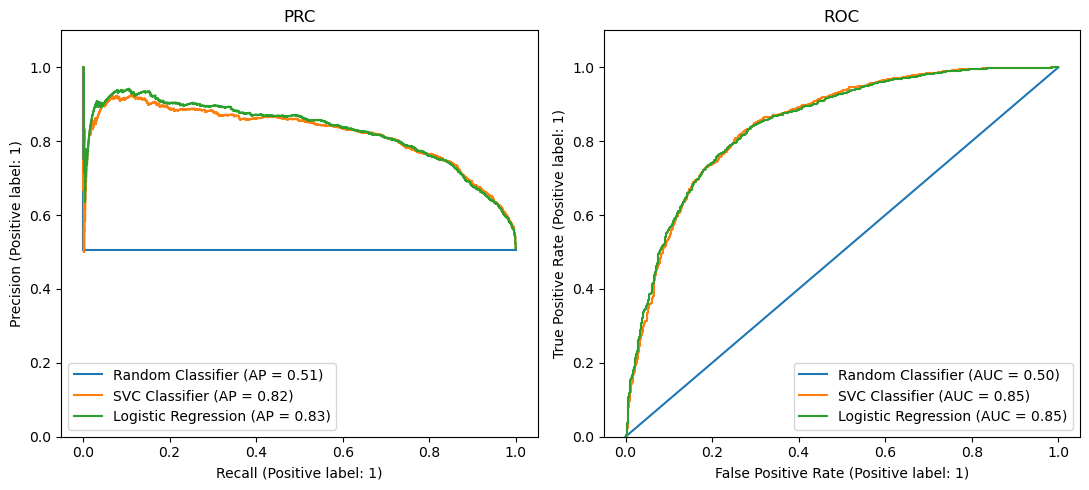

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_pred_proba_svc, 'SVC Classifier', ax)
depict_pr_roc(y_test, y_pred_proba_lr, 'Logistic Regression', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** На самом деле особо никаких различий нет, логистическая регрессия показывает слегка лучшие результаты на AUC-PR

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [93]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X, y)

SVC(kernel='linear', random_state=42)

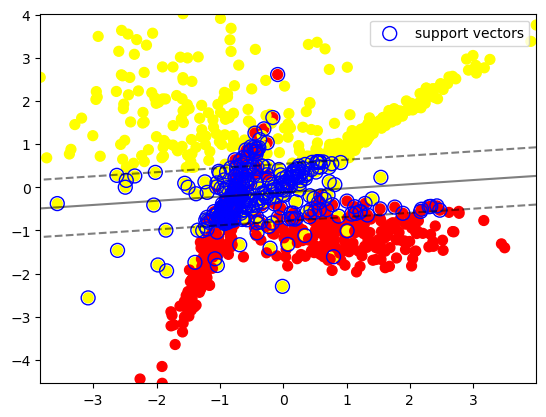

In [94]:
def plot_svm_2D(X, y, model, plot_support=True):
    # Создание сетки
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Предсказания модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    # Отрисовка разделяющей прямой
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовка выборки
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

    # Отрисовка опорных векторов
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                    s=100, linewidth=1, edgecolor="blue", facecolors='none', label='support vectors')

    plt.legend()

plot_svm_2D(X, y, svc_model)


**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** В данной визуализации опорные векторы — это точки, которые расположены ближе всего к разделяющей прямой (сплошная линия). Они важны, потому что именно они влияют на положение и ориентацию разделяющей прямой. Другие объекты, которые находятся дальше от разделяющей прямой, на её положение не влияют.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

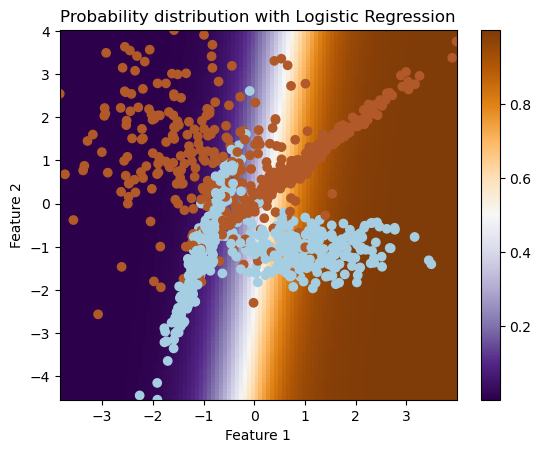

In [95]:
from sklearn.linear_model import LogisticRegression

# Обучение модели логистической регрессии
logreg_model = LogisticRegression()
logreg_model.fit(X, y)

def plot_logreg_2D(X, y, model):
    # Создание сетки
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Предсказание вероятностей для сетки
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape(XX.shape)

    # Отрисовка распределения вероятностей
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    # Отрисовка выборки
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    plt.colorbar(image)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Probability distribution with Logistic Regression')

# Визуализация распределения вероятностей с помощью логистической регрессии
plot_logreg_2D(X, y, logreg_model)


**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:**


*   она визуализирована белым цветом
*   Вероятность положительного класса в логистической регрессии моделируется через сигмоидную функцию $$ p(y=+1|x) = \frac{1}{1 + e^{-\langle w, x \rangle}}$$
Если $ -\langle w, x \rangle = 0$ (модель не уверена в прогнозе), то она будет выдавать вероятность $ p =  \frac{1}{1 + e^0}  = 0.5$





#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [96]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # была ошибка
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #была ошибка
    plt.plot(bin_middle_points, bin_real_ratios, label=name)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal Calibration')  # Добавление идеальной калибровочной кривой
    plt.xlabel('Средняя предсказанная вероятность')
    plt.ylabel('Доля единиц')
    plt.ylim([-0.05, 1.05])
    plt.title('Calibration Curve')
    plt.grid()
    plt.legend()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

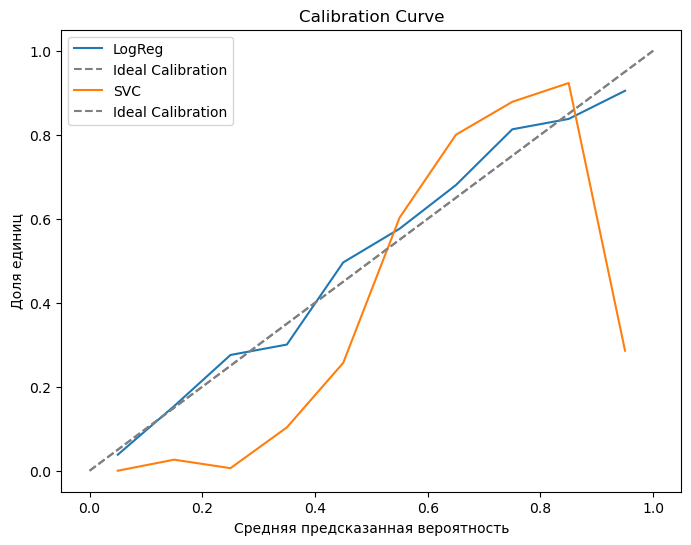

In [97]:
from sklearn.svm import LinearSVC
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_preds = logreg_model.predict_proba(X_test)[:,1]

svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)
svc_preds = svc_model.decision_function(X_test)
svc_preds = (svc_preds - svc_preds.min()) / (svc_preds.max() - svc_preds.min())

plt.figure(figsize=(8, 6))
plot_calibration_curve(y_test, logreg_preds, 'LogReg')
plot_calibration_curve(y_test, svc_preds, 'SVC')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** В обоих случаях калибровка ужасная, вероятности никак не отражаются (в случае если мы используем decision_function)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

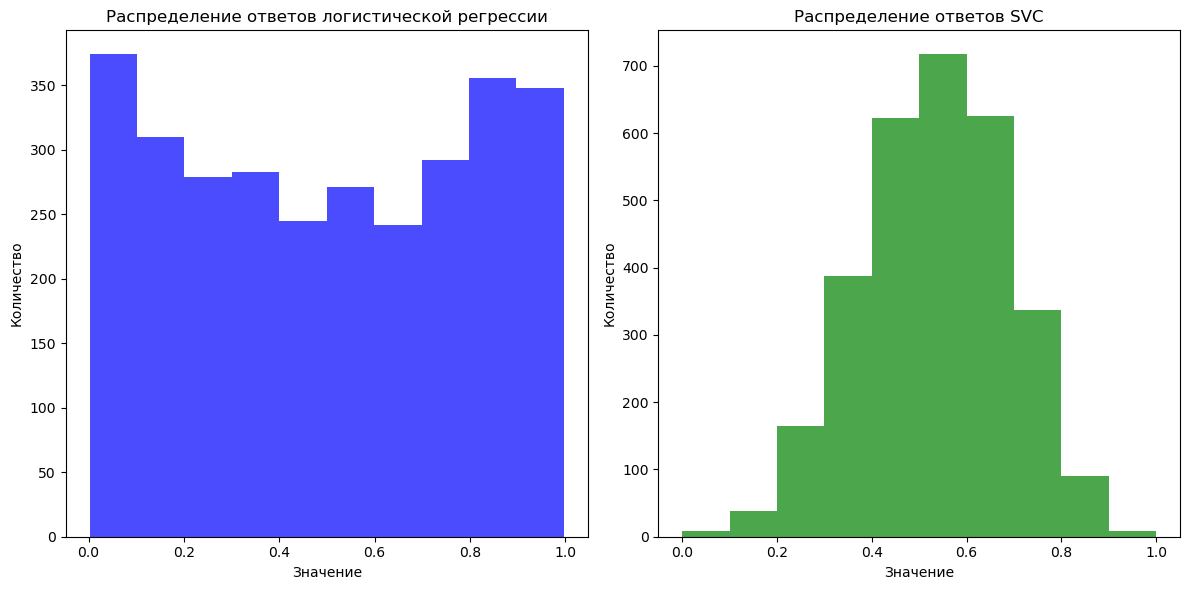

In [98]:
# Построение гистограмм для распределения ответов классификаторов

plt.figure(figsize=(12, 6))

# Гистограмма для логистической регрессии
plt.subplot(1, 2, 1)
plt.hist(logreg_preds, color='blue', alpha=0.7)
plt.title('Распределение ответов логистической регрессии')
plt.xlabel('Значение')
plt.ylabel('Количество')

# Гистограмма для SVC
plt.subplot(1, 2, 2)
plt.hist(svc_preds, color='green', alpha=0.7)
plt.title('Распределение ответов SVC')
plt.xlabel('Значение')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Распределение для логистической регрессии более равномерное, потому что функция логистической регресии лучше лучше определяет вероятности. Распределение для SVC нормальное, с мат ожиданием в области 0,5, что обусловлено тем, что опорные вектора проходят между точками двух классов, однако есть и точки, силно отдаленные от разделяющей плоскости, и когда мы нормируем результаты SVC, получается что в большинстве случаев модель выдает результаты близкие к 0,5 (может быть и наоборот - модель может выдавать значения близкие к 1 и 0 - если модель сильно уверена и точки далеко от опорных векторов)

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

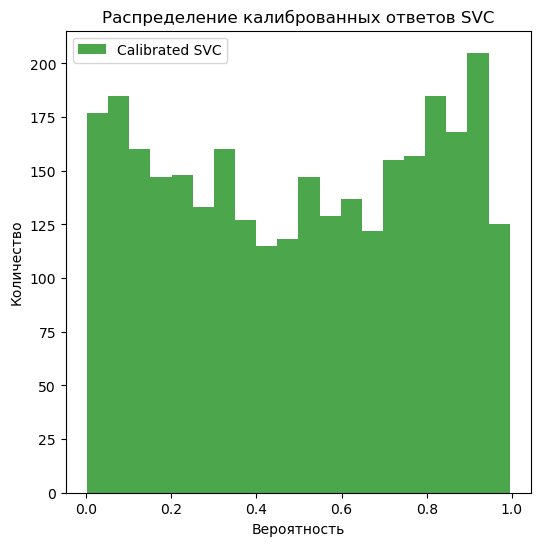

In [99]:
from sklearn.calibration import CalibratedClassifierCV
svc = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svc.fit(X_train, y_train)

calibrated_svc = CalibratedClassifierCV(base_estimator=svc, method='sigmoid', cv=3)
calibrated_svc.fit(X_train, y_train)
# Предсказания калиброванных вероятностей для тестовой выборки
calibrated_svc_preds = calibrated_svc.predict_proba(X_test)[:, 1]

# Построение гистограммы для калиброванных предсказаний
plt.figure(figsize=(6, 6))
plt.hist(calibrated_svc_preds, bins=20, color='green', alpha=0.7, label='Calibrated SVC')
plt.title('Распределение калиброванных ответов SVC')
plt.xlabel('Вероятность')
plt.ylabel('Количество')
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Да, значительно улучшилась. Теперь мы действительно получаем вероятности (лежащие в промежутке от 0 до 1)

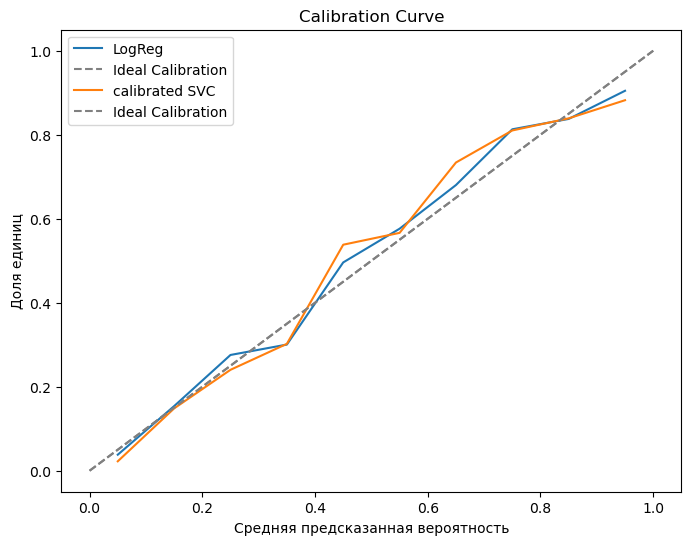

In [100]:
plt.figure(figsize=(8, 6))
plot_calibration_curve(y_test, logreg_preds, 'LogReg')
plot_calibration_curve(y_test, calibrated_svc_preds, 'calibrated SVC')
plt.show()

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [101]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [102]:
df = pd.read_csv('bike_buyers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [103]:
X

array([[ 1.97466438,  1.61558617, -0.37040336, ...,  0.81763962,
        -0.81371692, -0.21738731],
       [ 2.76652454,  3.53432402, -1.79801762, ...,  0.98655598,
        -1.3004601 ,  0.35890156],
       [-2.56471458, -2.96290226,  0.50106052, ...,  0.31155634,
         0.55402296, -0.52836359],
       ...,
       [-0.71054065,  4.58718893, -3.17450386, ..., -3.3310495 ,
        -5.01526968,  1.39888358],
       [-3.45487124, -2.45303243,  0.24143767, ..., -0.35332958,
         1.64386913,  0.31726181],
       [-0.3476568 , -2.86971296,  2.65920138, ..., -1.70422768,
         3.34662582,  0.26659057]])

In [104]:

df[df.select_dtypes(include=['object']).columns] = df[df.select_dtypes(include=['object']).columns].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')
X = X.fillna(X.mean()) #остальные значения - числа, поэтому заменяем средним
#Разделим на категориальные признаки и числовые
X_categorical = X[['Marital Status', 'Gender', 'Children', 'Education', 'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region', 'Age']]
X_numerical = X['Income']

В начале поработаем только с категориальными признаками

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [106]:
from sklearn.preprocessing import OrdinalEncoder
import time

start_time = time.time()
ordinal_encoder = OrdinalEncoder()

X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

logreg = LogisticRegression(max_iter=10000, random_state=777)

logreg.fit(X_train_encoded, y_train)
end_time = time.time()

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

res_0 = make_df(y_test, y_pred_proba, 'Ordinal Encoder')
print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 0.0339 seconds


In [107]:
res_0

,AUC_PR,AUC_ROC,reg_const
Ordinal Encoder,0.649704,0.667756,0.0


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [108]:
from sklearn.preprocessing import OneHotEncoder

start_time = time.time()
onehot_encoder = OneHotEncoder()

X_train_encoded = onehot_encoder.fit_transform(X_train)
X_test_encoded = onehot_encoder.transform(X_test)


logreg = LogisticRegression(max_iter=10000, random_state=777)

logreg.fit(X_train_encoded, y_train)
end_time = time.time()


y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

res_1 = make_df(y_test, y_pred_proba, 'OHE')
print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 0.0279 seconds


In [109]:
res_1

,AUC_PR,AUC_ROC,reg_const
OHE,0.690449,0.71141,0.0


In [110]:
res_0

,AUC_PR,AUC_ROC,reg_const
Ordinal Encoder,0.649704,0.667756,0.0


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [111]:
def mean_target_encoding(X_train, y_train, X_test):
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()
    X = pd.concat([X_train_, y_train], axis=1)

    category_means = {}

    for col in X_train_.columns:
        category_means[col] = X.groupby(col)[y_train.name].mean()

    for col in X_train_.columns:
        X_train_[col] = X_train_[col].map(category_means[col])
        X_test_[col] = X_test_[col].map(category_means[col])

    return X_train_, y_train, X_test_


start_time = time.time()

X_train_encoded, y_train, X_test_encoded = mean_target_encoding(X_train, y_train, X_test)

logreg = LogisticRegression(max_iter=10000, random_state=777)

logreg.fit(X_train_encoded, y_train)
end_time = time.time()


y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

res_2 = make_df(y_test, y_pred_proba, 'Counter')
print(f"Training time: {end_time - start_time:.4f} seconds")
#использовался GPT, я дал ему наброски своего кода, и он сгенерил это

Training time: 0.0199 seconds


In [112]:
res_2

,AUC_PR,AUC_ROC,reg_const
Counter,0.648411,0.656154,0.0




---
Можем видеть, что скоры получились примерно такие же (совсем незначительно ухудшились), тогда как столбцов гораздо меньше (новых столбцов не создается), что говорит о том, что этот тип кодирование не сильно уступает OHE в качестве, но сильно превосходит по количеству занимаемой памяти.


---



---




##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.mapping_dict = None

    def transform_column(self, col):
        col_name = col.name
        return col.astype(str) + "_" + col_name

    def fit(self, X, y):

        X_copy = X.copy()
        y_copy = y.copy()
        X_copy = X_copy.apply(self.transform_column)  # ПРЕДОБРАБОТКА
        X_full = X_copy.merge(y_copy, left_index=True, right_index=True)

        self.mapping_dict = pd.melt(X_full, id_vars=[y_copy.name], value_vars=list(X_copy.columns)).groupby('value')[y_copy.name].mean().to_dict()



        return self

    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = X_encoded.apply(self.transform_column)
        X_encoded = X_encoded.replace(self.mapping_dict)

        return X_encoded

start_time = time.time()

encoder = MeanTargetEncoder(categorical_columns=X_train.columns)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression(max_iter=10000, random_state=777)

logreg.fit(X_train_encoded, y_train)
end_time = time.time()

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

res_3 = make_df(y_test, y_pred_proba, 'Counter')
print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 0.0708 seconds


!**ВНИМАНИЕ**!
Реализация получилась менее эффективной (по времени) только за счет того, что в трансформере есть функция предобработки, которая позволяет работать не только с категориями, но и с числами, а также с повторяющимися категориями. В остальном все вычисления векторизованные и эффективные

In [114]:
res_3

,AUC_PR,AUC_ROC,reg_const
Counter,0.648411,0.656154,0.0


In [115]:
class MeanTargetEncoderMoreEffective(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_features = categorical_columns
        self.category_means = {}

    def fit(self, X, y):
        
        data = pd.concat([X[self.categorical_features], y], axis=1)

        self.category_means = {col: data.groupby(col)[y.name].mean() for col in self.categorical_features}

        return self

    def transform(self, X):

        X_transformed = X.copy()

        for col in self.categorical_features:
            X_transformed[col] = X_transformed[col].map(self.category_means[col]).fillna(X_transformed[col])

        return X_transformed
#использовался GPT, я дал ему трансормер циклом, и он сгенерил это

In [116]:
start_time = time.time()
encoder = MeanTargetEncoderMoreEffective(categorical_columns=X_train.columns)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression(max_iter=10000, random_state=777)

logreg.fit(X_train_encoded, y_train)
end_time = time.time()

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

res_3_5 = make_df(y_test, y_pred_proba, 'Counter')
print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 0.0229 seconds


!**Данная вариация является более эффективной, но не соотвествует условию задания**!

In [117]:
res_3_5

,AUC_PR,AUC_ROC,reg_const
Counter,0.648411,0.656154,0.0


___
Результаты работы всех методов сошлись
___

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую
регрессию, оцените качество.

In [118]:
encoder = MeanTargetEncoder(categorical_columns=X_categorical.columns)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

noise_level = 0.01
X_train_encoded += np.random.normal(0, noise_level, X_train_encoded.shape)
X_test_encoded += np.random.normal(0, noise_level, X_test_encoded.shape)

logreg = LogisticRegression(max_iter=10000, random_state=777)
logreg.fit(X_train_encoded, y_train)

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
res_4 = make_df(y_test, y_pred_proba, 'Noise')


In [119]:
res_4

,AUC_PR,AUC_ROC,reg_const
Noise,0.643821,0.651026,0.0


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Помогло (обычно помогает), но не сильно. Возможно потому что, шум все равно не может значительно изменить то, как обучается модель. Для этого лучше подходят другие способы

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).






---
Тут я реализую средний результат по фолдам


---




In [120]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import numpy as np

n_splits = 9
kf = KFold(n_splits=n_splits)
noise_level = 0.005

fold_encodings = {i: None for i in range(n_splits)}
encoder = MeanTargetEncoder(categorical_columns=X_train.columns)

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    encoder.fit(X_train_fold, y_train_fold)
    fold_encodings[i] = encoder.transform(X_train)

for i in range(n_splits):
    fold_encodings[i] = fold_encodings[i].applymap(lambda x: np.nan if isinstance(x, str) else x)
    fold_encodings[i] = fold_encodings[i].apply(lambda col: col.fillna(col.mean()))

X_train_encoded = np.mean([fold_encodings[i] for i in range(n_splits)], axis=0)

X_train_encoded += np.random.normal(0, noise_level, X_train_encoded.shape)

X_test_encoded = encoder.transform(X_test)
X_test_encoded += np.random.normal(0, noise_level, X_test_encoded.shape)

logreg = LogisticRegression(max_iter=10000, random_state=777)
logreg.fit(X_train_encoded, y_train)

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

res_5 = make_df(y_test, y_pred_proba, 'Folds')

#использовался GPT - передал ему словие задание (с контекстом прошлого кода), потом что-то редактировал

In [121]:
res_5

,AUC_PR,AUC_ROC,reg_const
Folds,0.654229,0.648333,0.0


In [122]:
res_3

,AUC_PR,AUC_ROC,reg_const
Counter,0.648411,0.656154,0.0




---
Как видно, сильно улучшить результаты не получилось в виду того, что когда мы разбиваем выборку на валидационную, тестовую и тренировочную, появляются значения, которые есть в валидационной выборке, но которых нет в тестовой, из-за чего приходится заменять их на среднее по таблице, что может искажать качество модели


---








#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [123]:
class MeanTargetEncoderSmoothed(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, C=10):
        self.categorical_columns = categorical_columns
        self.C = C
        self.mapping_dict = {}  # Инициализация как пустой словарь
        self.global_mean = None

    def fit(self, X, y):
        X_copy = X.copy()
        y_copy = y.copy()
        self.global_mean = 0.001

        X_full = X_copy.merge(y_copy, left_index=True, right_index=True)

        for col in self.categorical_columns:
            category_means = X_full.groupby(col)[y_copy.name].agg(['mean', 'count'])
            smooth_means = (category_means['mean'] * category_means['count'] + self.global_mean * self.C) / (category_means['count'] + self.C)
            self.mapping_dict[col] = smooth_means.to_dict()

        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_columns:
            X_encoded[col] = X_encoded[col].map(self.mapping_dict[col]).fillna(self.global_mean)
        return X_encoded

# использовался GPT
# скинул предыдущий код и дал на вход задание

In [124]:
best_c, best_score = None, -np.inf  
best_res = None

for c in np.logspace(-5, 5, 40):
    print("Тестируем", c, "пожалуйста, подождите")
    encoder = MeanTargetEncoderSmoothed(categorical_columns=X_train.columns, C=c)
    encoder.fit(X_train, y_train)
    X_train_encoded = encoder.transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    logreg = LogisticRegression(max_iter=10000, random_state=777)
    logreg.fit(X_train_encoded, y_train)
    y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

    res_counter_smooth = make_df(y_test, y_pred_proba, 'Smoothed counter')

    current_score = list((res_counter_smooth['AUC_ROC'].values))[0]
    if current_score > best_score:  
        best_c = c
        best_score = current_score
        best_res = res_counter_smooth

print("Лучшее C:", best_c, "со значением AUC-PR:", best_score)

Тестируем 1e-05 пожалуйста, подождите
Тестируем 1.80472176682717e-05 пожалуйста, подождите
Тестируем 3.257020655659783e-05 пожалуйста, подождите
Тестируем 5.878016072274912e-05 пожалуйста, подождите
Тестируем 0.00010608183551394483 пожалуйста, подождите
Тестируем 0.00019144819761699575 пожалуйста, подождите
Тестируем 0.0003455107294592218 пожалуйста, подождите
Тестируем 0.0006235507341273912 пожалуйста, подождите
Тестируем 0.0011253355826007646 пожалуйста, подождите
Тестируем 0.002030917620904735 пожалуйста, подождите
Тестируем 0.003665241237079626 пожалуйста, подождите
Тестируем 0.006614740641230145 пожалуйста, подождите
Тестируем 0.011937766417144358 пожалуйста, подождите
Тестируем 0.021544346900318822 пожалуйста, подождите
Тестируем 0.03888155180308085 пожалуйста, подождите
Тестируем 0.07017038286703822 пожалуйста, подождите
Тестируем 0.1266380173467402 пожалуйста, подождите
Тестируем 0.22854638641349884 пожалуйста, подождите
Тестируем 0.4124626382901348 пожалуйста, подождите
Тестир

In [125]:
best_res

,AUC_PR,AUC_ROC,reg_const
Smoothed counter,0.704864,0.712628,0.0




---
Экспериментальным методом было обнаружено, что наилучшее качество классификатор выдает тогда, когда global_mean соотвествует не среднему целевой переменной а числу, близкому нулю. Таким образом, получилось значительно улучшить качество по срвнению с OHE (результаты OHE ниже)


---




In [126]:
res_1

,AUC_PR,AUC_ROC,reg_const
OHE,0.690449,0.71141,0.0


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [127]:
X_numerical = X_numerical.fillna(X_numerical.mean())

In [128]:
X_numerical

0       40000.0
1       30000.0
2       80000.0
3       70000.0
4       30000.0
         ...   
995     60000.0
996     70000.0
997     60000.0
998    100000.0
999     60000.0
Name: Income, Length: 1000, dtype: float64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [129]:
unique_counts = X_numerical.nunique()
print(unique_counts)

17


In [130]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

**Обычный счетчик**

!**Внимание**! Ранее я объявил категориальными признаками все, кроме дохода, так как, несмотря на числовой формат, они являются категории, поэтому в числовых признаках у меня только доход

In [131]:
cols = list(X_categorical.columns)
encoder = MeanTargetEncoder(cols)
encoder.fit(X_train_full[cols], y_train_full)
X_train_encoded = encoder.transform(X_train_full[cols])
X_test_encoded = encoder.transform(X_test_full[cols])

logreg = LogisticRegression(max_iter=10000, random_state=777)
logreg.fit(X_train_encoded[cols], y_train_full)

y_pred_proba = logreg.predict_proba(X_test_encoded[cols])[:, 1]

res_counter_full = make_df(y_test_full, y_pred_proba, 'categorial')
print(res_counter_full)

              AUC_PR   AUC_ROC  reg_const
categorial  0.648411  0.656154        0.0


In [132]:
cols = list(X_categorical.columns) + [X_numerical.name]
encoder = MeanTargetEncoder(cols)
encoder.fit(X_train_full[cols], y_train_full)
X_train_encoded = encoder.transform(X_train_full[cols])
X_test_encoded = encoder.transform(X_test_full[cols])

logreg = LogisticRegression(max_iter=10000, random_state=777)
logreg.fit(X_train_encoded[cols], y_train_full)

y_pred_proba = logreg.predict_proba(X_test_encoded[cols])[:, 1]

res_counter_full = make_df(y_test_full, y_pred_proba, 'Full')
print(res_counter_full)

        AUC_PR   AUC_ROC  reg_const
Full  0.662933  0.674872        0.0


**Сглаженный счетчик**

In [133]:
cols = list(X_categorical.columns)
encoder = MeanTargetEncoderSmoothed(cols, C=best_c)
encoder.fit(X_train_full[cols], y_train_full)
X_train_encoded = encoder.transform(X_train_full[cols])
X_test_encoded = encoder.transform(X_test_full[cols])

logreg = LogisticRegression(max_iter=10000, random_state=777)
logreg.fit(X_train_encoded[cols], y_train_full)

y_pred_proba = logreg.predict_proba(X_test_encoded[cols])[:, 1]

res_counter_full = make_df(y_test_full, y_pred_proba, 'categorial')
print(res_counter_full)

              AUC_PR   AUC_ROC  reg_const
categorial  0.704864  0.712628        0.0


In [134]:
cols = list(X_categorical.columns) + [X_numerical.name]
encoder = MeanTargetEncoderSmoothed(cols, C=best_c)
encoder.fit(X_train_full[cols], y_train_full)
X_train_encoded = encoder.transform(X_train_full[cols])
X_test_encoded = encoder.transform(X_test_full[cols])

logreg = LogisticRegression(max_iter=10000, random_state=777)
logreg.fit(X_train_encoded[cols], y_train_full)

y_pred_proba = logreg.predict_proba(X_test_encoded[cols])[:, 1]

res_counter_full = make_df(y_test_full, y_pred_proba, 'Full')
print(res_counter_full)

        AUC_PR   AUC_ROC  reg_const
Full  0.705069  0.711859        0.0


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__


*   Счетчики значительно уменьшают размерность и экономят память
*   В своем обычном испольнении немного менее точный, чем OHE
*   Работает дольше чем OHE (у меня)



# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [135]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [136]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [137]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [138]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
old_features_num = len(X_train.columns)
enc = OneHotEncoder()
X_train_categorical_encoded = enc.fit_transform(X_train[categorical_features])
X_train_categorical_encoded_dense = X_train_categorical_encoded.toarray()
new_feature_names = enc.get_feature_names_out(input_features=categorical_features)
X_train_categorical_encoded_df = pd.DataFrame(X_train_categorical_encoded_dense, columns=new_feature_names, index=X_train.index)
X_train_encoded = X_train.drop(columns=categorical_features).join(X_train_categorical_encoded_df)
X_test_categorical_encoded = enc.transform(X_test[categorical_features])
X_test_categorical_encoded_dense = X_test_categorical_encoded.toarray()
X_test_categorical_encoded_df = pd.DataFrame(X_test_categorical_encoded_dense, columns=new_feature_names, index=X_test.index)
X_test_encoded = X_test.drop(columns=categorical_features).join(X_test_categorical_encoded_df)

print(f'Стало на {len(X_train_encoded.columns) - old_features_num} больше')

Стало на 94 больше


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [139]:
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state = 777)
logreg.fit(X_train_encoded, y_train)


y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]


auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR на тестовой выборке: {auc_pr}")

AUC-PR на тестовой выборке: 0.4504242709496442


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [140]:
from sklearn.linear_model import LogisticRegression
import time as time

start_time = time.time()
log_reg = LogisticRegression()
log_reg.fit(X_train_encoded, y_train)

feature_importance = np.abs(log_reg.coef_[0])
feature_names = X_train_encoded.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(40)
end_time = time.time()

X_train_top_features = X_train_encoded[feature_importance_df['Feature'].values]
X_test_top_features = X_test_encoded[feature_importance_df['Feature'].values]

logreg.fit(X_train_top_features, y_train)


y_pred_proba = logreg.predict_proba(X_test_top_features)


print(f"Время отбора: {end_time - start_time} секунд")

auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"AUC-PR на тестовой выборке: {auc_pr}")

Время отбора: 0.26628851890563965 секунд
AUC-PR на тестовой выборке: 0.7572206992103245


Изменилось ли качество? Как?

Качество выросло в 1,5 раза

In [141]:
feature_importance_df

,Feature,Importance
5,hours-per-week,0.008046
0,age,0.007124
2,education-num,0.001673
4,capital-loss,0.000795
35,marital-status_ Never-married,0.000475
33,marital-status_ Married-civ-spouse,0.000382
64,sex_ Female,0.000376
53,relationship_ Husband,0.000341
3,capital-gain,0.000336
10,workclass_ Private,0.000315


Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [142]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = X_train.columns.difference(categorical_features)


scaler = MinMaxScaler()


X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])

X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features, index=X_train.index)
X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features, index=X_test.index)

X_train_scaled = pd.concat([X_train_numerical, X_train[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_numerical, X_test[categorical_features]], axis=1)
X_train_scaled

,age,capital-gain,capital-loss,education-num,fnlwgt,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
14004,0.589041,0.031030,0.0,0.866667,0.126090,0.397959,State-gov,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States
21060,0.328767,0.000000,0.0,0.600000,0.009967,0.397959,Local-gov,Some-college,Divorced,Exec-managerial,Not-in-family,White,Female,United-States
7926,0.013699,0.000000,0.0,0.600000,0.106343,0.295918,Private,Some-college,Never-married,Other-service,Own-child,White,Female,United-States
11552,0.602740,0.000000,0.0,0.533333,0.071190,0.397959,Local-gov,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,United-States
15648,0.123288,0.000000,0.0,0.600000,0.056488,0.551020,Self-emp-not-inc,Some-college,Married-civ-spouse,Sales,Husband,White,Male,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0.041096,0.000000,0.0,0.533333,0.057138,0.193878,Private,HS-grad,Never-married,Adm-clerical,Own-child,Black,Female,United-States
21382,0.616438,0.000000,0.0,0.866667,0.020447,0.500000,Local-gov,Masters,Separated,Prof-specialty,Not-in-family,White,Female,?
10830,0.410959,0.000000,0.0,0.533333,0.096863,0.397959,Private,HS-grad,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States
14560,0.219178,0.072981,0.0,0.533333,0.145471,0.448980,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States


In [143]:
X_train_encoded = X_train_encoded.drop(numerical_features, axis=1)

X_train_encoded = pd.concat([X_train_encoded, X_train_numerical], axis=1)
X_test_encoded = X_test_encoded.drop(numerical_features, axis=1)

X_test_encoded = pd.concat([X_test_encoded, X_test_numerical], axis=1)
X_train_encoded

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,capital-gain,capital-loss,education-num,fnlwgt,hours-per-week
14004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.589041,0.031030,0.0,0.866667,0.126090,0.397959
21060,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.328767,0.000000,0.0,0.600000,0.009967,0.397959
7926,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.013699,0.000000,0.0,0.600000,0.106343,0.295918
11552,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [144]:
start_time = time.time()
log_reg = LogisticRegression()
log_reg.fit(X_train_encoded, y_train)

feature_importance = np.abs(log_reg.coef_[0])
feature_names = X_train_encoded.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(40)
end_time = time.time()

X_train_top_features = X_train_encoded[feature_importance_df['Feature'].values]
X_test_top_features = X_test_encoded[feature_importance_df['Feature'].values]

logreg.fit(X_train_top_features, y_train)


y_pred_proba = logreg.predict_proba(X_test_top_features)

print(f"Время отбора: {end_time - start_time} секунд")

auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"AUC-PR на тестовой выборке: {auc_pr}")

Время отбора: 0.34607505798339844 секунд
AUC-PR на тестовой выборке: 0.743971892069563


___
Видно, что с помощью данного метода отбор осуществляется достаточно неплохо - качество ухудшилось, но не сильно
___

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [145]:
X_train_numerical = scaler.fit_transform(X_train_encoded)
X_test_numerical = scaler.transform(X_test_encoded)


X_train_numerical = pd.DataFrame(X_train_numerical, columns=X_train_encoded.columns, index=X_train.index)
X_test_numerical = pd.DataFrame(X_test_numerical, columns=X_test_encoded.columns, index=X_test.index)
X_train_numerical

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,capital-gain,capital-loss,education-num,fnlwgt,hours-per-week
14004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.589041,0.031030,0.0,0.866667,0.126090,0.397959
21060,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.328767,0.000000,0.0,0.600000,0.009967,0.397959
7926,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.013699,0.000000,0.0,0.600000,0.106343,0.295918
11552,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,



---
Как видно, дата одинаковая


---




In [146]:
start_time = time.time()
log_reg = LogisticRegression()
log_reg.fit(X_train_numerical, y_train)

feature_importance = np.abs(log_reg.coef_[0])
feature_names = X_train_encoded.columns


feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(40)
end_time = time.time()

X_train_top_features = X_train_numerical[feature_importance_df['Feature'].values]
X_test_top_features = X_test_numerical[feature_importance_df['Feature'].values]

logreg.fit(X_train_top_features, y_train)


y_pred_proba = logreg.predict_proba(X_test_top_features)

print(f"Время отбора: {end_time - start_time} секунд")

auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"AUC-PR на тестовой выборке: {auc_pr}")

Время отбора: 0.3445887565612793 секунд
AUC-PR на тестовой выборке: 0.743971892069563




---

Качество соотвественно тоже не меняется


---



#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [147]:
from time import time
positive_class = X_train_encoded[y_train == 1]
negative_class = X_train_encoded[y_train == 0]

t_statistics = []

start_time = time()

for feature in X_train_encoded.columns:
    mu_pos = np.mean(positive_class[feature])
    mu_neg = np.mean(negative_class[feature])
    sigma_pos = np.var(positive_class[feature])
    sigma_neg = np.var(negative_class[feature])
    n_pos = positive_class[feature].shape[0]
    n_neg = negative_class[feature].shape[0]

    t_stat = np.abs(mu_pos - mu_neg) / np.sqrt(((n_pos * sigma_pos) + (n_neg * sigma_neg)) / (n_pos + n_neg))
    t_statistics.append((feature, t_stat))


top_40_features = sorted(t_statistics, key=lambda x: x[1], reverse=True)[:40]
top_40_features = [feature[0] for feature in top_40_features]


end_time = time()


X_train_top40 = X_train_encoded[top_40_features]
X_test_top40 = X_test_encoded[top_40_features]

logreg.fit(X_train_top40, y_train)


y_pred_proba = logreg.predict_proba(X_test_top40)

print(f"Время отбора: {end_time - start_time} секунд")

auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"AUC-PR на тестовой выборке: {auc_pr}")
#использовался GPT, promt: условие

Время отбора: 0.030426025390625 секунд
AUC-PR на тестовой выборке: 0.7529624603407487


___
Этот метод отбирает признаки почти идеально. Как видно, качество упало совсем незначительно - на несколько тысячных
___

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [148]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from tqdm import tqdm

start_time = time.time()
X_train_internal, X_val_internal, y_train_internal, y_val_internal = train_test_split(
    X_train_encoded, y_train, test_size=0.5, random_state=42
)

while len(X_train_internal.columns) > 40:
    scores = {}
    for column in tqdm(X_train_internal.columns):
      X_train, X_test = X_train_internal.copy(), X_val_internal.copy()
      X_train = X_train.drop(column, axis=1)
      X_test = X_test.drop(column, axis=1)
      logreg.fit(X_train, y_train_internal)
      preds = logreg.predict_proba(X_test)[:, 1]

      scores[column] = average_precision_score(y_val_internal, preds)
    feature_to_remove = max(scores, key=scores.get)
    print(feature_to_remove)

    X_train_internal = X_train_internal.drop(feature_to_remove, axis=1)
    X_val_internal = X_val_internal.drop(feature_to_remove, axis=1)
    
end_time = time.time()

100%|██████████| 108/108 [00:32<00:00,  3.29it/s]


occupation_ Protective-serv


100%|██████████| 107/107 [00:39<00:00,  2.73it/s]


occupation_ Craft-repair


100%|██████████| 106/106 [00:31<00:00,  3.36it/s]


marital-status_ Married-civ-spouse


100%|██████████| 105/105 [00:26<00:00,  3.90it/s]


native-country_ United-States


100%|██████████| 104/104 [00:25<00:00,  4.14it/s]


native-country_ Iran


100%|██████████| 103/103 [00:24<00:00,  4.20it/s]


native-country_ Taiwan


100%|██████████| 102/102 [00:23<00:00,  4.29it/s]


education_ 11th


100%|██████████| 101/101 [00:23<00:00,  4.32it/s]


education_ Assoc-voc


100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


native-country_ Haiti


100%|██████████| 99/99 [00:25<00:00,  3.89it/s]


native-country_ Ecuador


100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


native-country_ Dominican-Republic


100%|██████████| 97/97 [00:24<00:00,  3.90it/s]


native-country_ Trinadad&Tobago


100%|██████████| 96/96 [00:27<00:00,  3.47it/s]


workclass_ Self-emp-inc


100%|██████████| 95/95 [00:25<00:00,  3.68it/s]


workclass_ Local-gov


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


native-country_ Greece


100%|██████████| 93/93 [00:20<00:00,  4.45it/s]


native-country_ Italy


100%|██████████| 92/92 [00:22<00:00,  4.15it/s]


education_ 7th-8th


100%|██████████| 91/91 [00:21<00:00,  4.15it/s]


education_ 9th


100%|██████████| 90/90 [00:21<00:00,  4.23it/s]


relationship_ Wife


100%|██████████| 89/89 [00:21<00:00,  4.18it/s]


occupation_ Sales


100%|██████████| 88/88 [00:24<00:00,  3.63it/s]


education_ Prof-school


100%|██████████| 87/87 [00:19<00:00,  4.44it/s]


education_ HS-grad


100%|██████████| 86/86 [00:22<00:00,  3.85it/s]


education_ Some-college


100%|██████████| 85/85 [00:23<00:00,  3.61it/s]


education_ Masters


100%|██████████| 84/84 [00:19<00:00,  4.31it/s]


workclass_ Private


100%|██████████| 83/83 [00:17<00:00,  4.62it/s]


native-country_ Cambodia


100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


native-country_ Ireland


100%|██████████| 81/81 [00:15<00:00,  5.17it/s]


marital-status_ Divorced


100%|██████████| 80/80 [00:17<00:00,  4.54it/s]


marital-status_ Widowed


100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


education_ Doctorate


100%|██████████| 78/78 [00:17<00:00,  4.52it/s]


native-country_ Hong


100%|██████████| 77/77 [00:16<00:00,  4.71it/s]


native-country_ El-Salvador


100%|██████████| 76/76 [00:18<00:00,  4.17it/s]


native-country_ Laos


100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


native-country_ Thailand


100%|██████████| 74/74 [00:15<00:00,  4.66it/s]


race_ White


100%|██████████| 73/73 [00:12<00:00,  5.72it/s]


race_ Black


100%|██████████| 72/72 [00:11<00:00,  6.09it/s]


sex_ Male


100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


native-country_ Holand-Netherlands


100%|██████████| 70/70 [00:09<00:00,  7.17it/s]


workclass_ ?


100%|██████████| 69/69 [00:08<00:00,  8.06it/s]


native-country_ Scotland


100%|██████████| 68/68 [00:08<00:00,  8.02it/s]


race_ Asian-Pac-Islander


100%|██████████| 67/67 [00:08<00:00,  7.62it/s]


education_ 12th


100%|██████████| 66/66 [00:08<00:00,  7.45it/s]


native-country_ Honduras


100%|██████████| 65/65 [00:07<00:00,  8.22it/s]


workclass_ Never-worked


100%|██████████| 64/64 [00:07<00:00,  8.02it/s]


native-country_ Poland


100%|██████████| 63/63 [00:07<00:00,  8.70it/s]


native-country_ Cuba


100%|██████████| 62/62 [00:07<00:00,  8.47it/s]


education_ Preschool


100%|██████████| 61/61 [00:06<00:00,  8.94it/s]


native-country_ Portugal


100%|██████████| 60/60 [00:07<00:00,  8.06it/s]


native-country_ Japan


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


native-country_ Guatemala


100%|██████████| 58/58 [00:07<00:00,  7.38it/s]


occupation_ Armed-Forces


100%|██████████| 57/57 [00:05<00:00,  9.58it/s]


native-country_ Yugoslavia


100%|██████████| 56/56 [00:05<00:00,  9.49it/s]


native-country_ Hungary


100%|██████████| 55/55 [00:05<00:00,  9.52it/s]


native-country_ China


100%|██████████| 54/54 [00:05<00:00,  9.71it/s]


marital-status_ Separated


100%|██████████| 53/53 [00:05<00:00, 10.16it/s]


education_ 10th


100%|██████████| 52/52 [00:05<00:00,  9.07it/s]


native-country_ England


100%|██████████| 51/51 [00:05<00:00,  9.68it/s]


workclass_ State-gov


100%|██████████| 50/50 [00:05<00:00,  9.74it/s]


native-country_ Philippines


100%|██████████| 49/49 [00:04<00:00,  9.94it/s]


native-country_ Peru


100%|██████████| 48/48 [00:04<00:00, 10.80it/s]


native-country_ Outlying-US(Guam-USVI-etc)


100%|██████████| 47/47 [00:04<00:00, 10.82it/s]


native-country_ South


100%|██████████| 46/46 [00:04<00:00,  9.84it/s]


native-country_ Jamaica


100%|██████████| 45/45 [00:04<00:00, 10.49it/s]


workclass_ Without-pay


100%|██████████| 44/44 [00:03<00:00, 11.94it/s]


occupation_ Priv-house-serv


100%|██████████| 43/43 [00:03<00:00, 12.48it/s]


education_ Bachelors


100%|██████████| 42/42 [00:03<00:00, 12.15it/s]


race_ Other


100%|██████████| 41/41 [00:03<00:00, 12.94it/s]

native-country_ Nicaragua


In [149]:
top_40_features = X_train_internal.columns
X_train_top40 = X_train_encoded[top_40_features]
X_test_top40 = X_test_encoded[top_40_features]

logreg.fit(X_train_top40, y_train)


y_pred_proba = logreg.predict_proba(X_test_top40)

print(f"Время отбора: {end_time - start_time} секунд")

auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"AUC-PR на тестовой выборке: {auc_pr}")
#использовался GPT, promt: условие

Время отбора: 1017.0314300060272 секунд
AUC-PR на тестовой выборке: 0.7566725664415961


___
Этот метод показал результаты еще лучше по сравнению с полным числом признаков скор упал на сколько-то десятитысячных, однако отбор занял нереально много времени
___

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [150]:
import time
start_time = time.time()

X_train_internal, X_val_internal, y_train_internal, y_val_internal = train_test_split(
    X_train_encoded, y_train, test_size=0.5, random_state=42
)

selected_features = []
remaining_features = list(X_train_encoded.columns)
current_best_score = -float('inf')
while len(selected_features) < 40:
    scores = {}
    for column in tqdm(remaining_features):
        X_train = X_train_internal[selected_features + [column]]
        X_val = X_val_internal[selected_features + [column]]

        logreg.fit(X_train, y_train_internal)
        preds = logreg.predict_proba(X_val)[:, 1]
        scores[column] = average_precision_score(y_val_internal, preds)

    feature_to_add = max(scores, key=scores.get)
    if scores[feature_to_add] < current_best_score: 
        break
    print(current_best_score)
    current_best_score = scores[feature_to_add]

    print(f"Adding feature: {feature_to_add}")
    selected_features.append(feature_to_add)
    remaining_features.remove(feature_to_add)

end_time = time.time()

100%|██████████| 108/108 [00:01<00:00, 74.25it/s]


-inf
Adding feature: education-num


100%|██████████| 107/107 [00:01<00:00, 58.88it/s]


0.4615810835955426
Adding feature: marital-status_ Married-civ-spouse


100%|██████████| 106/106 [00:01<00:00, 53.37it/s]


0.6266494184472334
Adding feature: capital-gain


100%|██████████| 105/105 [00:02<00:00, 44.70it/s]


0.6822456319786157
Adding feature: age


100%|██████████| 104/104 [00:02<00:00, 37.01it/s]


0.7108955084784935
Adding feature: capital-loss


100%|██████████| 103/103 [00:03<00:00, 31.52it/s]


0.7237798543820745
Adding feature: occupation_ Exec-managerial


100%|██████████| 102/102 [00:03<00:00, 32.51it/s]


0.7316786639297383
Adding feature: hours-per-week


100%|██████████| 101/101 [00:03<00:00, 26.59it/s]


0.7372270273594885
Adding feature: workclass_ Self-emp-not-inc


100%|██████████| 100/100 [00:03<00:00, 26.23it/s]


0.7419956542707061
Adding feature: occupation_ Prof-specialty


100%|██████████| 99/99 [00:04<00:00, 21.87it/s]


0.7449401880239944
Adding feature: occupation_ Farming-fishing


100%|██████████| 98/98 [00:04<00:00, 22.30it/s]


0.7468505152954348
Adding feature: occupation_ Other-service


100%|██████████| 97/97 [00:03<00:00, 24.57it/s]


0.748410013134204
Adding feature: relationship_ Own-child


100%|██████████| 96/96 [00:04<00:00, 19.92it/s]


0.7499606422066841
Adding feature: workclass_ Federal-gov


100%|██████████| 95/95 [00:05<00:00, 18.77it/s]


0.7512501710160511
Adding feature: occupation_ Tech-support


100%|██████████| 94/94 [00:04<00:00, 21.56it/s]


0.7522154517222907
Adding feature: occupation_ ?


100%|██████████| 93/93 [00:04<00:00, 22.92it/s]


0.7530501707266664
Adding feature: relationship_ Other-relative


100%|██████████| 92/92 [00:04<00:00, 21.89it/s]


0.7535893111868547
Adding feature: native-country_ Columbia


100%|██████████| 91/91 [00:04<00:00, 20.05it/s]


0.7540008851903295
Adding feature: marital-status_ Never-married


100%|██████████| 90/90 [00:04<00:00, 21.85it/s]


0.7544166440806641
Adding feature: education_ Assoc-acdm


100%|██████████| 89/89 [00:03<00:00, 22.50it/s]


0.7548477156387058
Adding feature: relationship_ Unmarried


100%|██████████| 88/88 [00:04<00:00, 19.37it/s]


0.7552040169895362
Adding feature: fnlwgt


100%|██████████| 87/87 [00:04<00:00, 18.28it/s]


0.7555788656963937
Adding feature: native-country_ ?


100%|██████████| 86/86 [00:04<00:00, 18.71it/s]


0.7558363028362074
Adding feature: occupation_ Transport-moving


100%|██████████| 85/85 [00:04<00:00, 20.50it/s]


0.7560841129271547
Adding feature: marital-status_ Married-AF-spouse


100%|██████████| 84/84 [00:05<00:00, 14.67it/s]


0.756301034180647
Adding feature: native-country_ Mexico


100%|██████████| 83/83 [00:05<00:00, 15.96it/s]


0.7565326824480026
Adding feature: occupation_ Machine-op-inspct


100%|██████████| 82/82 [00:04<00:00, 16.72it/s]


0.7567469348810554
Adding feature: occupation_ Handlers-cleaners


100%|██████████| 81/81 [00:05<00:00, 15.50it/s]


0.7569983952360806
Adding feature: native-country_ Puerto-Rico


100%|██████████| 80/80 [00:05<00:00, 14.92it/s]


0.7571665487819641
Adding feature: race_ Amer-Indian-Eskimo


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


0.7573073754675042
Adding feature: native-country_ India


100%|██████████| 78/78 [00:05<00:00, 13.18it/s]


0.7574414529265668
Adding feature: native-country_ France


100%|██████████| 77/77 [00:04<00:00, 15.56it/s]


0.7575616310696094
Adding feature: native-country_ Germany


100%|██████████| 76/76 [00:05<00:00, 14.61it/s]


0.7576592012443875
Adding feature: education_ 5th-6th


100%|██████████| 75/75 [00:05<00:00, 13.67it/s]


0.7577706828766159
Adding feature: relationship_ Husband


100%|██████████| 74/74 [00:05<00:00, 13.09it/s]


0.7578711550453807
Adding feature: sex_ Male


100%|██████████| 73/73 [00:06<00:00, 11.06it/s]


0.7593660179085525
Adding feature: relationship_ Wife


100%|██████████| 72/72 [00:06<00:00, 10.67it/s]


0.7594777072761604
Adding feature: education_ 1st-4th


100%|██████████| 71/71 [00:05<00:00, 12.38it/s]


0.7595783818171817
Adding feature: native-country_ Vietnam


100%|██████████| 70/70 [00:06<00:00, 10.80it/s]


0.7596654688591893
Adding feature: native-country_ Canada


100%|██████████| 69/69 [00:05<00:00, 11.72it/s]

0.7597361100667933
Adding feature: native-country_ Nicaragua


In [151]:
top_40_features = selected_features
X_train_top40 = X_train_encoded[top_40_features]
X_test_top40 = X_test_encoded[top_40_features]

logreg.fit(X_train_top40, y_train)


y_pred_proba = logreg.predict_proba(X_test_top40)

print(f"Время отбора: {end_time - start_time} секунд")

auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"AUC-PR на тестовой выборке: {auc_pr}")
#использовался GPT, promt: условие

Время отбора: 181.15626645088196 секунд
AUC-PR на тестовой выборке: 0.7565087759635473


___
Такой порог, скорее всего, найдется, но он не лежит в топ-40 признаках
___

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
* Отбор линейной функциией - самый простой и очевидный, но работает он дольше и результате выдает хуже, чем отбор через t-статистику
* Отбор через t-статистику лучше всего применим, если необходимо произвести отбор в кратчайшее время, его скор наилучший за такое короткое время
* Отбор оборткой (удаление) показывает наилучший результат, но требует огромного количество времени/вычилительных мощностей
* Отбор оборткой (добавление), по моему мнению, является универсальным способом, так как выдает результат чуть-чуть хуже, чем отбор оберткой(удаление), а работает значительно быстрее

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [152]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [153]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [154]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [155]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)

X_train = {}
X_test = {}
y_train = {}
y_test = {}

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train[i] = X.iloc[train_index]
    X_test[i] = X.iloc[test_index]
    y_train[i] = y.iloc[train_index]
    y_test[i] = y.iloc[test_index]

In [156]:
X_train.keys()

dict_keys([0, 1, 2, 3, 4])

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [157]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [158]:
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

numerical_cols = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=777))])

models = {}
predictions = {}
scores = {}

for i in range(len(X_train)):

    models[i] = model.fit(X_train[i], y_train[i])
    predictions[i] = models[i].predict(X_test[i])
    scores[i] = accuracy_score(y_test[i], predictions[i])

scores

{0: 0.9037387715464918,
 1: 0.8997329448895363,
 2: 0.8969410050983249,
 3: 0.9072477843875197,
 4: 0.8909797256282627}

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [159]:

income_per_positive = 10  
cost_per_call = 1 


revenues = []
for i in range(len(X_test)):
    calls_made = np.sum(predictions[i])

    true_positives = np.sum((predictions[i] == 1) & (y_test[i] == 1))

    revenue = true_positives * income_per_positive - calls_made * cost_per_call
    revenues.append(revenue)

average_revenue = np.mean(revenues)
std_deviation = np.std(revenues, ddof=1)

average_calls_cost = cost_per_call * np.mean([np.sum(predictions[i]) for i in range(len(X_test))])

print("Средняя выручка:", average_revenue)
print("Стандартное отклонение выручки:", std_deviation)
print("Средние расходы на звонки:", average_calls_cost)
##использовался GPT, promt: условие, предыдущий код для контекста

Средняя выручка: 1804.4
Стандартное отклонение выручки: 116.90722817687535
Средние расходы на звонки: 323.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [160]:
revenues_random = []
for i in range(len(X_test)):
    calls_made = np.sum(predictions[i])

    true_positives = np.sum((predictions[i] == 1) & (y_test[i] == 1))

    income_from_positives = np.sum(np.random.uniform(0, 20, true_positives))
    revenue = income_from_positives - calls_made * cost_per_call
    revenues_random.append(revenue)

average_revenue_random = np.mean(revenues_random)
std_deviation_random = np.std(revenues_random)

print("Средняя выручка с учетом случайности:", average_revenue_random)
print("Стандартное отклонение выручки:", std_deviation_random)

Средняя выручка с учетом случайности: 1796.928298362514
Стандартное отклонение выручки: 116.9483181205479


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

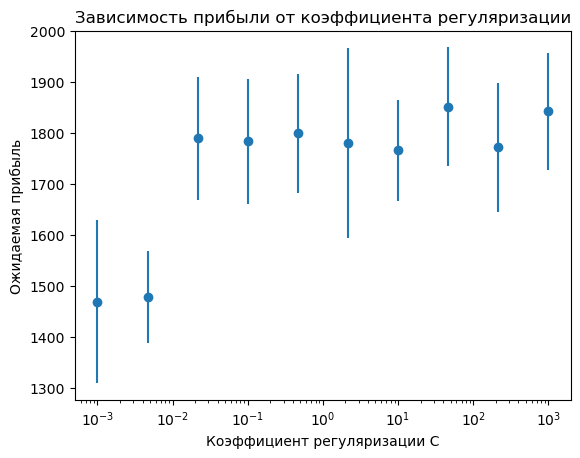

46.41588833612773 1851.3159141885844


In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def draw():
  def profit_score(estimator, X, y):
      predictions = estimator.predict(X)

      calls_made = np.sum(predictions)

      true_positives = np.sum((predictions == 1) & (y == 1))

      income_from_positives = np.sum(np.random.uniform(0, 20, true_positives))

      return income_from_positives - calls_made * cost_per_call

  C_values = np.logspace(-3, 3, 10)

  profits = []
  std_devs = []

  for C in C_values:
      model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(C=C, random_state=777))])

      scores = cross_val_score(model, X, y, cv=kf, scoring=profit_score)

      profits.append(np.mean(scores))
      std_devs.append(np.std(scores))

  plt.errorbar(C_values, profits, yerr=std_devs, fmt='o')
  plt.xscale('log')
  plt.xlabel('Коэффициент регуляризации C')
  plt.ylabel('Ожидаемая прибыль')
  plt.title('Зависимость прибыли от коэффициента регуляризации')
  plt.show()

  optimal_C = C_values[np.argmax(profits)]
  optimal_profit = max(profits)
  optimal_C, optimal_profit
  print(optimal_C, optimal_profit)
draw()
#использовался GPT, promt: условие, предыдущий код для контекста

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?



---
Нет, каждый раз коэффициенты абсолютно разные,


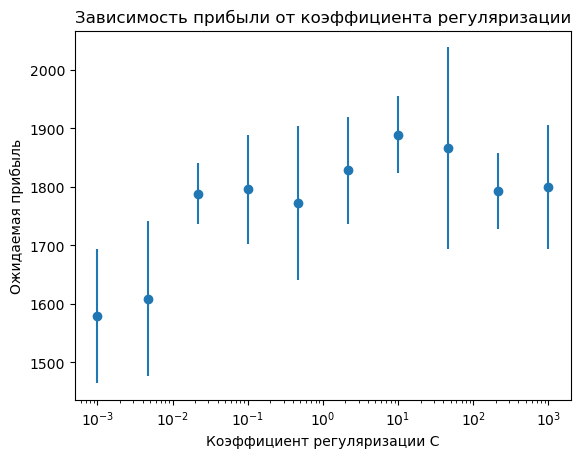

10.0 1889.235615125611


In [162]:
draw()

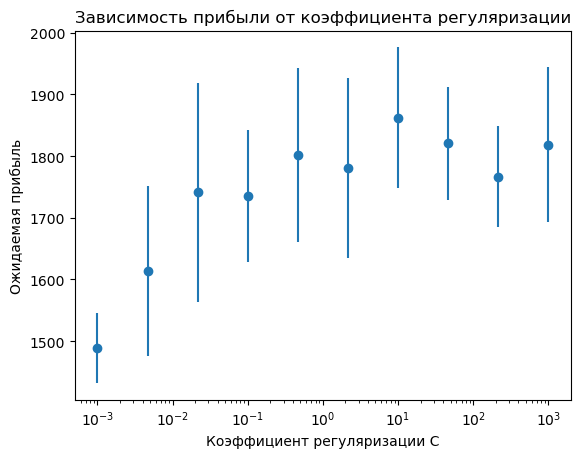

10.0 1862.3409232621802


In [163]:
draw()

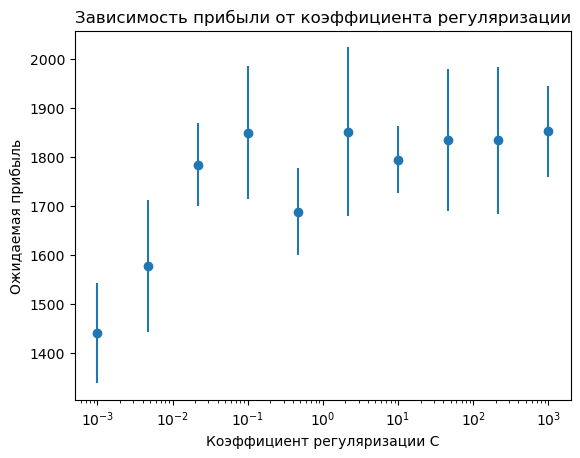

1000.0 1851.9444961687018


In [164]:
draw()



---


Так как значения выручки рандомные, регуляризацией мы можем повлиять на итог крайне мало, по сути она бесполезна


---



#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ важнее пресижн, потому что для максимизации важно, чтобы было как можно больше именно точных звонков, так как за каждый неправильный звонок компания теряет в выручке


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [165]:
from sklearn.metrics import make_scorer

def profit_with_threshold(estimator, X, y, threshold):
    probabilities = estimator.predict_proba(X)[:, 1]

    predictions = (probabilities >= threshold).astype(int)

    calls_made = np.sum(predictions)

    true_positives = np.sum((predictions == 1) & (y == 1))

    income_from_positives = np.sum(np.random.uniform(0, 20, true_positives))

    return income_from_positives - calls_made * cost_per_call

thresholds = np.arange(0, 1.01, 0.01)

max_profit = -np.inf
optimal_threshold = 0

for threshold in thresholds:
    total_profit = 0
    for i in range(len(X_train)):
        model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LogisticRegression(random_state=777))])
        model.fit(X_train[i], y_train[i])
        profit = profit_with_threshold(model, X_test[i], y_test[i], threshold)
        total_profit += profit

    avg_profit = total_profit / len(X_train)
    if avg_profit > max_profit:
        max_profit = avg_profit
        optimal_threshold = threshold

optimal_threshold, max_profit
#использовался GPT, promt: условие, предыдущий код для контекста

(0.12, 4234.158409030637)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




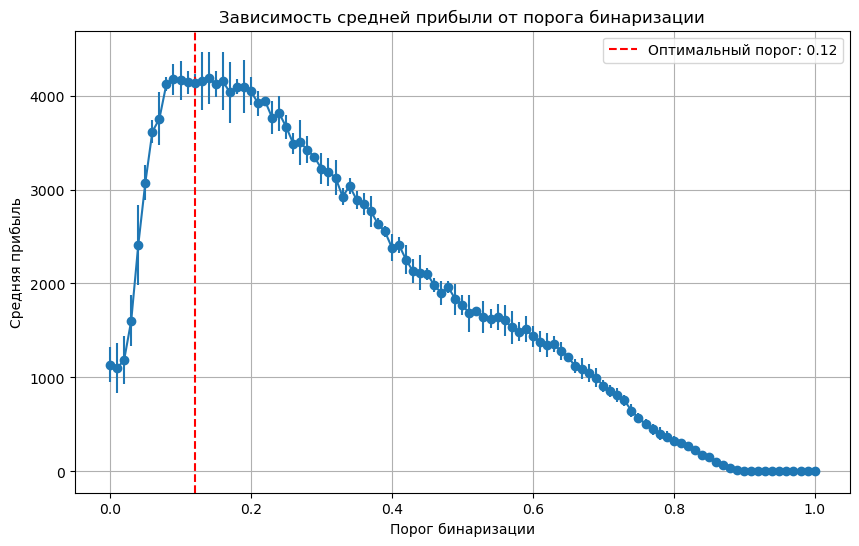

In [166]:
profits = []
std_devs = []

for threshold in thresholds:
    threshold_profits = []
    for i in range(len(X_train)):
        model.fit(X_train[i], y_train[i])
        profit = profit_with_threshold(model, X_test[i], y_test[i], threshold)
        threshold_profits.append(profit)

    avg_profit = np.mean(threshold_profits)
    std_dev = np.std(threshold_profits)
    profits.append(avg_profit)
    std_devs.append(std_dev)

plt.figure(figsize=(10, 6))
plt.errorbar(thresholds, profits, yerr=std_devs, fmt='-o')
plt.xlabel('Порог бинаризации')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость средней прибыли от порога бинаризации')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Оптимальный порог: {optimal_threshold:.2f}')
plt.legend()
plt.grid(True)
plt.show()
#использовался GPT, promt: условие, предыдущий код для контекста

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?



---
При множественных генерация порог получается примерно один и тот же. Порог достаточно маленький- +- 0,1. То есть в данном случае нам не настолько важен precision, как recall. Это связано с тем, что за правильный звонок мы получаем гораздо больший выигрыш, чем за неправильный, поэтому имеет смысл рисковать. Более того, порог получается равен отношению предельных затрат на правильный звонок к предельным выгодам от правилного звонка.

---



Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [167]:
from sklearn.metrics import precision_score, recall_score

precisions = []
recalls = []

optimal_threshold = 0.11

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    probabilities = model.predict_proba(X_test)[:, 1]
    predictions = probabilities >= optimal_threshold

    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    precisions.append(precision)
    recalls.append(recall)

avg_precision = np.mean(precisions)
std_dev_precision = np.std(precisions)
avg_recall = np.mean(recalls)
std_dev_recall = np.std(recalls)

avg_precision, std_dev_precision, avg_recall, std_dev_recall
#использовался GPT, promt: условие

(0.33642929233823865,
 0.01249279060135921,
 0.6418251126381084,
 0.020443896409984234)

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [168]:
from sklearn.metrics import precision_recall_curve, auc

probabilities = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

filtered_precision = precision[recall >= 0.5]
filtered_recall = recall[recall >= 0.5]

normalized_recall = (filtered_recall - 0.5) / (1 - 0.5)

pr_auc = auc(normalized_recall, filtered_precision)

print("PR-AUC в зоне recall >= 0.5:", pr_auc)
#использовался GPT, promt: условиеНапи

PR-AUC в зоне recall >= 0.5: 0.26275473087181733


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ поел яблоко. В день сдачи (среду), у меня военка, поэтому на похавать есть 0,5 минут, если я хочу хоть немного поспать

Памятка по GPT: как и раньше я использовал его, чтобы не писать весь код с нуля или чтобы получить идею по реализации, затем допиливвал самостоятельно. В редких случаях, когда GPT совсем сильно тупил, приходилось писать все абсолютно самому. Также он отлично рисует графики. С эим справляется отлично.